In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import pickle

# NLTK for text processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer

# TensorFlow and Keras for building and training neural network models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

# Sklearn for preprocessing and model evaluation
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import speech_recognition as sr

nltk.download('punkt')
nltk.download('stopwords')

# Import additional library for classification report
from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vinnu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vinnu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load the dataset
dataset_path = 'cyberbullying_tweets.csv'
df = pd.read_csv(dataset_path)

# Display the first few rows of the dataframe
print(df.head())


                                          tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying


Unique labels: ['not_cyberbullying' 'gender' 'religion' 'other_cyberbullying' 'age'
 'ethnicity']
Number of rows in the dataset: 47692
Label distribution:
 cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64


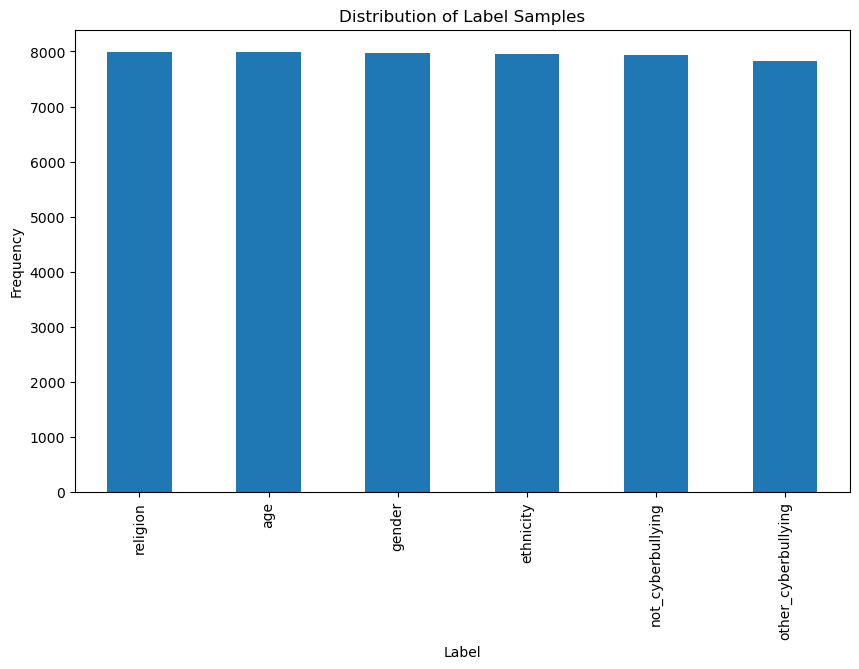

In [3]:
# Remove rows with NaN values in 'tweet_text' and 'cyberbullying_type' columns
df = df.dropna(subset=['tweet_text', 'cyberbullying_type'])

# Extract unique labels from the 'cyberbullying_type' column
unique_labels = df['cyberbullying_type'].unique()
print("Unique labels:", unique_labels)

# Print the number of rows in the dataset
print("Number of rows in the dataset:", df.shape[0])

# Print the distribution of label samples
label_distribution = df['cyberbullying_type'].value_counts()
print("Label distribution:\n", label_distribution)

# Plot the distribution of labels
plt.figure(figsize=(10, 6))
label_distribution.plot(kind='bar')
plt.title('Distribution of Label Samples')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()


In [4]:
# Initialize the stemmer
stemmer = PorterStemmer()

def clean_and_preprocess_text(text):
    # Normalization: Removing URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Removing user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lowercasing
    text = text.lower()
    # Sentence Segmentation
    sentences = sent_tokenize(text)
    processed_text = []
    for sentence in sentences:
        # Tokenization
        tokens = word_tokenize(sentence)
        # Stop Word Removal
        tokens = [token for token in tokens if token not in stopwords.words('english')]
        tokens = [stemmer.stem(token) for token in tokens]
        processed_text.extend(tokens)
    return " ".join(processed_text)

# Apply the preprocessing function to the cleaned DataFrame
df['cleaned_text'] = df['tweet_text'].apply(clean_and_preprocess_text)

# Display the cleaned and preprocessed text
print(df[['tweet_text', 'cleaned_text']].head())

# Fit the Tokenizer on the cleaned text
tokenizer = Tokenizer(num_words=10000)  # Adjust num_words as needed
tokenizer.fit_on_texts(df['cleaned_text'])

# Convert text to sequences
X_sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

# Pad the sequences
maxlen = 200
X_padded = pad_sequences(X_sequences, maxlen=maxlen)

# Encode the labels
encoder = LabelBinarizer()
y_encoded = encoder.fit_transform(df['cyberbullying_type'])

# Verify alignment
assert X_padded.shape[0] == y_encoded.shape[0], "Features and labels are misaligned."


                                          tweet_text  \
0  In other words #katandandre, your food was cra...   
1  Why is #aussietv so white? #MKR #theblock #ImA...   
2  @XochitlSuckkks a classy whore? Or more red ve...   
3  @Jason_Gio meh. :P  thanks for the heads up, b...   
4  @RudhoeEnglish This is an ISIS account pretend...   

                                        cleaned_text  
0                 word katandandr food crapilici mkr  
1  aussietv white mkr theblock imacelebrityau tod...  
2                     classi whore red velvet cupcak  
3  meh p thank head concern anoth angri dude twitter  
4  isi account pretend kurdish account like islam...  


In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.20, random_state=42)

# Load GloVe embeddings
embeddings_dictionary = dict()
with open('glove.6B.200d.txt', encoding="utf8") as glove_file:
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        if vector_dimensions.shape[0] == 200:
            embeddings_dictionary[word] = vector_dimensions

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 200))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        if index < len(embedding_matrix):
            embedding_matrix[index] = embedding_vector

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Bi-LSTM with Callbacks
model_bi_lstm_callbacks = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 200, weights=[embedding_matrix], input_length=maxlen, trainable=False),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(y_encoded.shape[1], activation='softmax')
])

model_bi_lstm_callbacks.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

history_bi_lstm_callbacks = model_bi_lstm_callbacks.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=128, callbacks=[early_stopping, reduce_lr], verbose=1)

# Save the tokenizer and encoder for future use
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('label_encoder.pickle', 'wb') as handle:
    pickle.dump(encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the model
model_save_path_bi_lstm_callbacks = 'Cyber_Bullying_model_bi_lstm_final.h5'
model_bi_lstm_callbacks.save(model_save_path_bi_lstm_callbacks)
print(f"Bi-LSTM Model with callbacks saved to {model_save_path_bi_lstm_callbacks}")


C:\Users\vinnu\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 136s 550ms/step - accuracy: 0.2383 - loss: 1.7499 - precision: 0.4500 - recall: 0.0016 - val_accuracy: 0.6187 - val_loss: 1.2844 - val_precision: 0.9773 - val_recall: 0.1186 - learning_rate: 1.0000e-04
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 138s 577ms/step - accuracy: 0.5039 - loss: 1.2894 - precision: 0.8577 - recall: 0.1985 - val_accuracy: 0.7110 - val_loss: 0.7811 - val_precision: 0.9164 - val_recall: 0.5188 - learning_rate: 1.0000e-04
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 146s 609ms/step - accuracy: 0.6236 - loss: 0.9738 - precision: 0.8375 - recall: 0.4187 - val_accuracy: 0.7467 - val_loss: 0.6613 - val_precision: 0.9189 - val_recall: 0.5658 - learning_rate: 1.0000e-04
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 148s 621ms/step - accuracy: 0.6807 - loss: 0.8399 - precision: 0.8373 - recall: 0.5096 - val_accuracy: 0.7581 - val_loss: 0.6094 - val_precision: 0.9190 - val_recall: 0.5885 - learning_rate: 1.0000e-04
Epoch 5/30
239/239 ━━━━━━━━━━━━━

Bi-LSTM Model with callbacks saved to Cyber_Bullying_model_bi_lstm_final.h5


In [6]:
# Evaluate the model on the test data
results = model_bi_lstm_callbacks.evaluate(X_test, y_test)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}, Test Precision: {results[2]}, Test Recall: {results[3]}")


299/299 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.8046 - loss: 0.4775 - precision: 0.8851 - recall: 0.7269
Test Loss: 0.4903239607810974, Test Accuracy: 0.8009225130081177, Test Precision: 0.8789072632789612, Test Recall: 0.7251284122467041


In [7]:
from sklearn.metrics import classification_report


In [8]:
# Make predictions on the test set
y_pred_prob = model_bi_lstm_callbacks.predict(X_test)

# Convert the probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate and print the classification report
report = classification_report(y_true, y_pred, target_names=encoder.classes_)
print("Classification Report:\n", report)


299/299 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step
Classification Report:
                      precision    recall  f1-score   support

                age       0.95      0.98      0.97      1603
          ethnicity       0.97      0.95      0.96      1603
             gender       0.87      0.77      0.82      1531
  not_cyberbullying       0.59      0.43      0.50      1624
other_cyberbullying       0.54      0.75      0.63      1612
           religion       0.94      0.94      0.94      1566

           accuracy                           0.80      9539
          macro avg       0.81      0.80      0.80      9539
       weighted avg       0.81      0.80      0.80      9539



In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

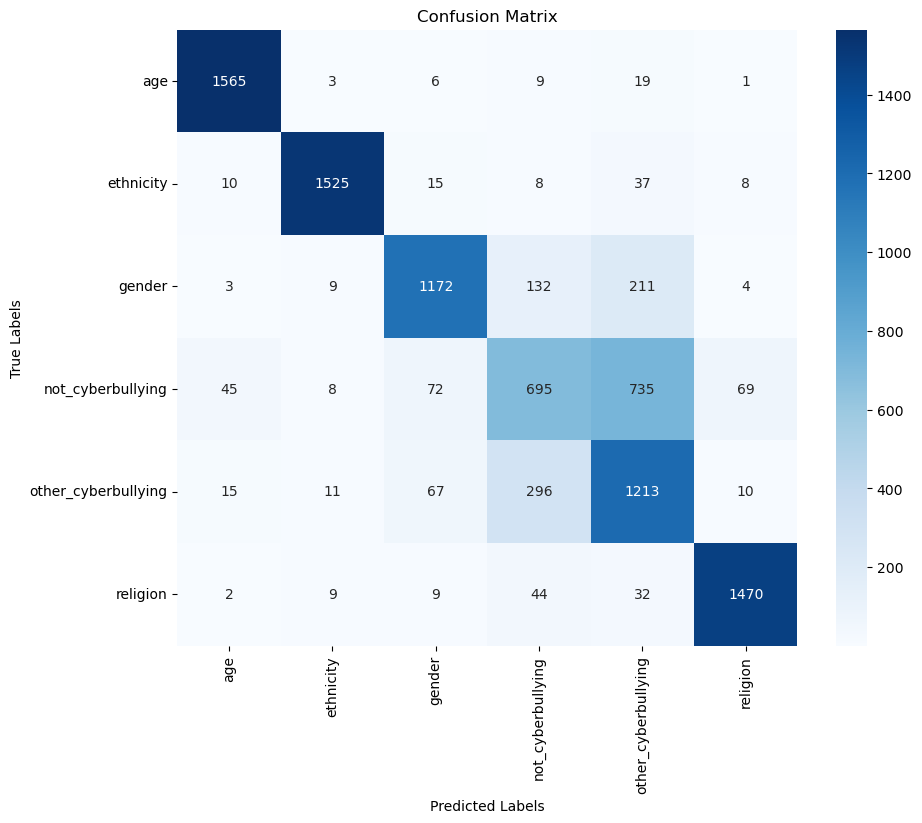

In [10]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

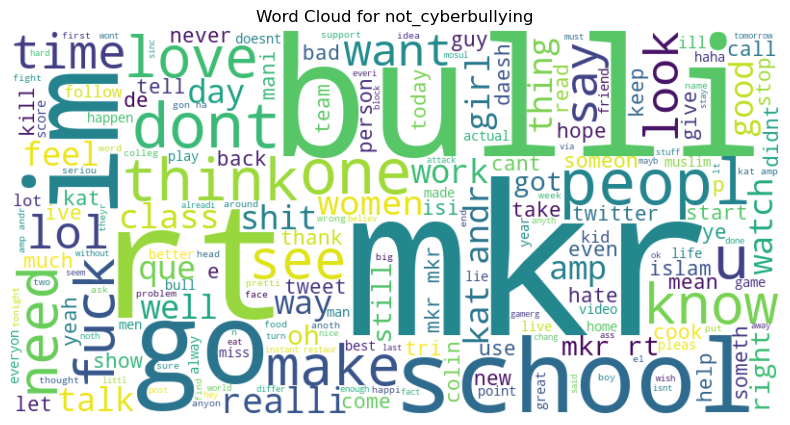

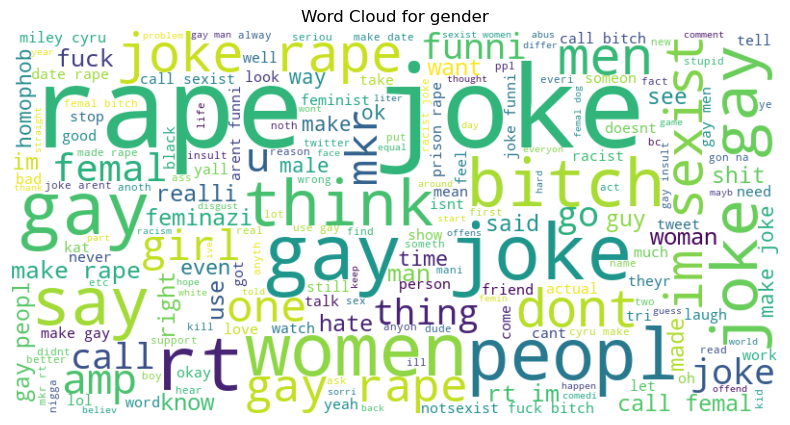

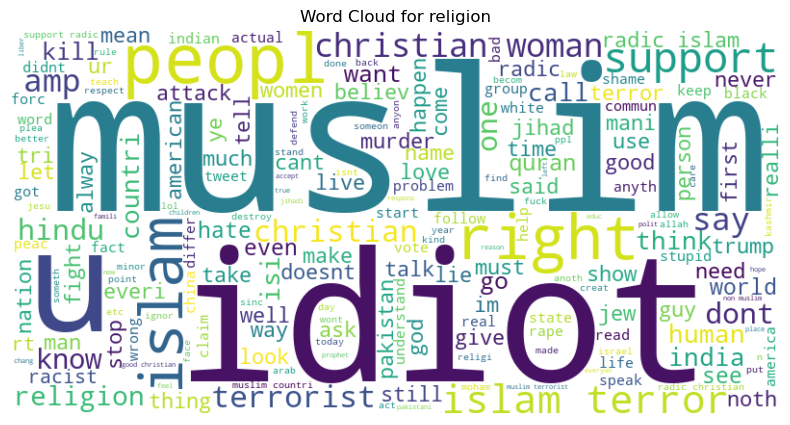

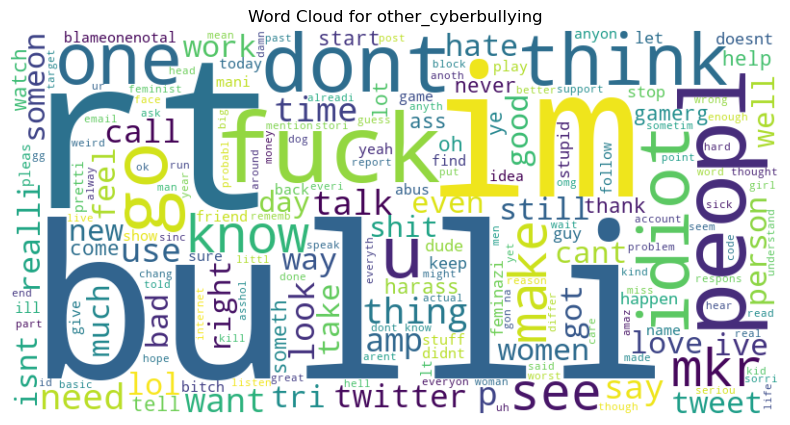

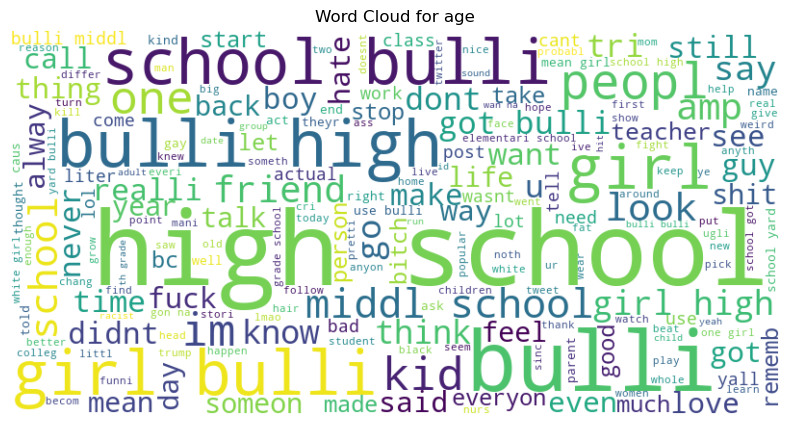

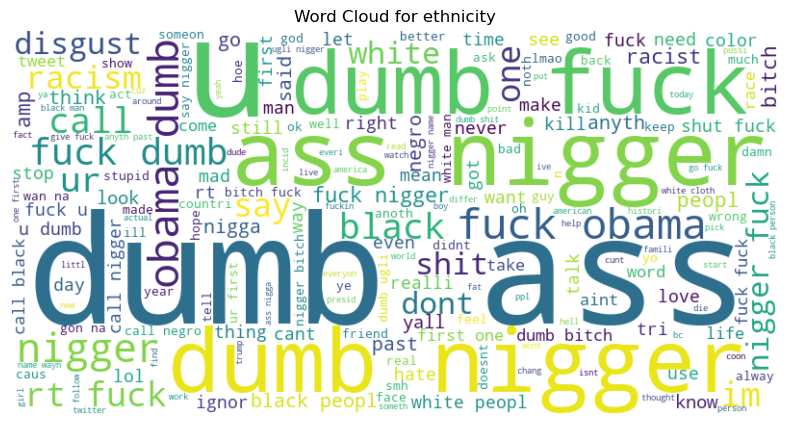

In [7]:
from wordcloud import WordCloud
# Generate word clouds for each label
labels = df['cyberbullying_type'].unique()

for label in labels:
    text = " ".join(df[df['cyberbullying_type'] == label]['cleaned_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {label}')
    plt.show()

Label: not_cyberbullying
mkr: 1692
bulli: 1167
rt: 790
im: 483
get: 427
like: 426
go: 397
school: 377
dont: 373
kat: 292

Label: gender
joke: 5350
rape: 4214
gay: 4013
call: 1407
make: 1347
rt: 1250
bitch: 1164
femal: 1114
im: 1102
peopl: 999

Label: religion
muslim: 4639
idiot: 3081
islam: 2458
christian: 2152
u: 1463
terrorist: 1387
right: 1304
like: 1276
support: 1260
dont: 1191

Label: other_cyberbullying
bulli: 942
rt: 897
im: 753
fuck: 547
like: 508
get: 489
dont: 476
peopl: 428
go: 360
know: 313

Label: age
bulli: 9031
school: 8538
high: 4945
girl: 4665
like: 2086
get: 1057
one: 1045
peopl: 935
im: 916
got: 848

Label: ethnicity
fuck: 6053
nigger: 5615
dumb: 5163
ass: 2289
black: 2153
u: 1802
white: 1577
call: 1385
peopl: 1191
rt: 1190



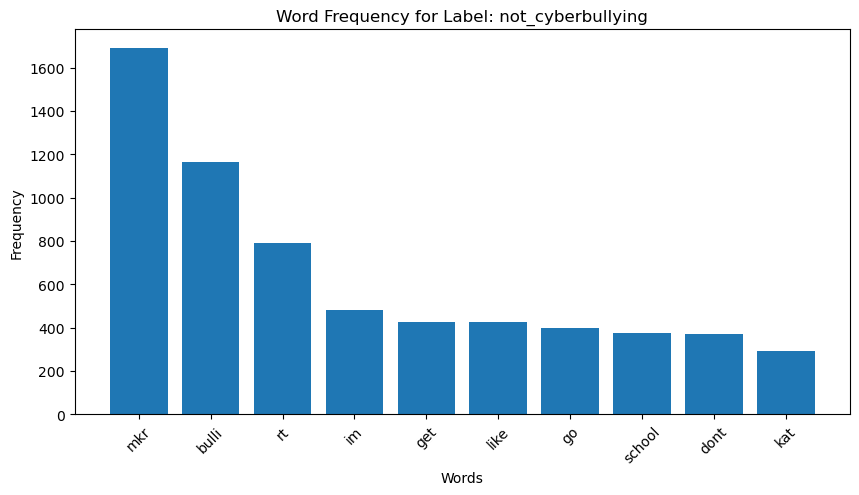

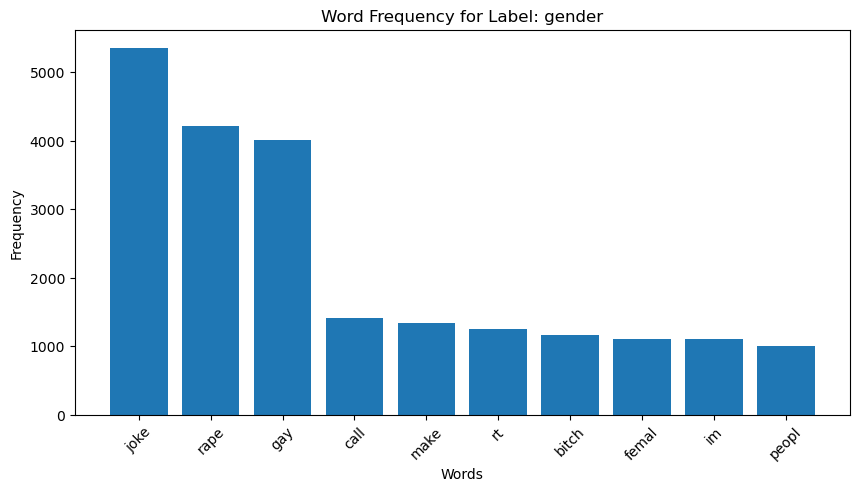

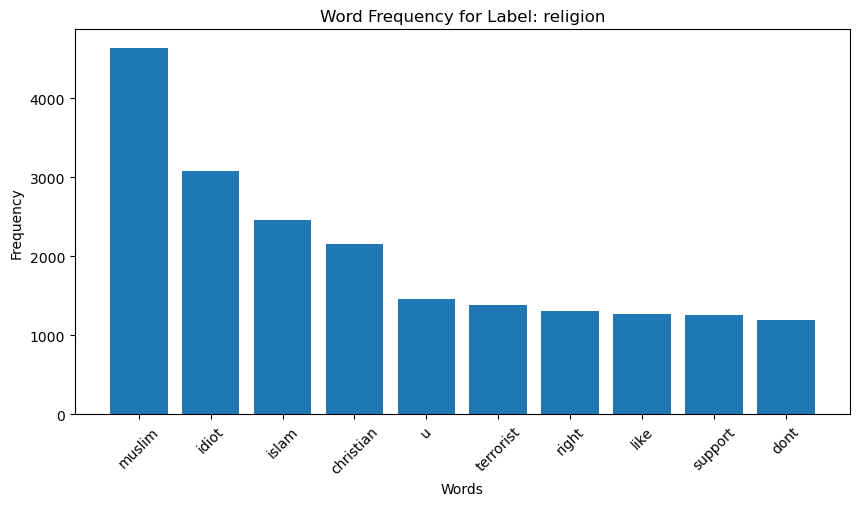

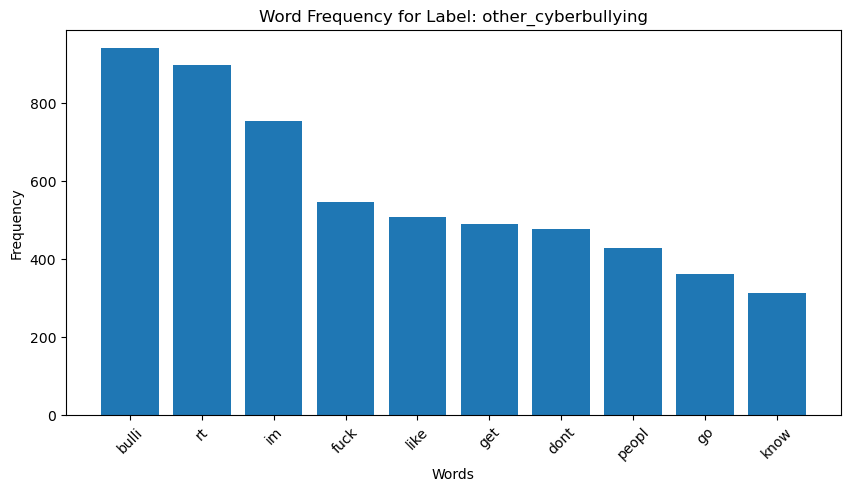

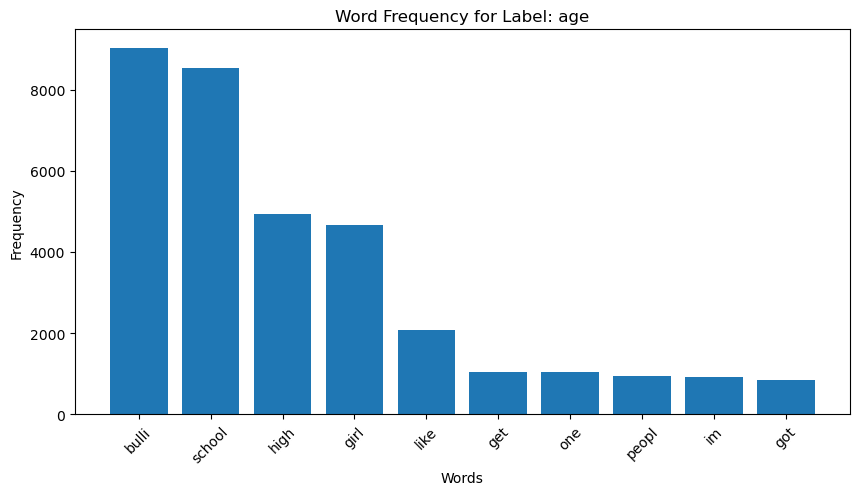

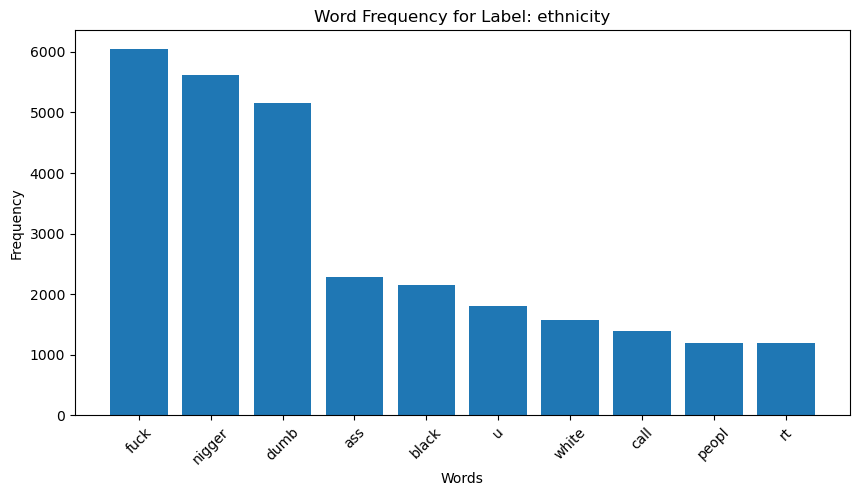

In [11]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Function to calculate word frequency for each label
def calculate_word_frequency_per_label(df, label_column, text_column):
    label_word_freq = {}
    labels = df[label_column].unique()
    
    for label in labels:
        label_data = df[df[label_column] == label]
        all_words = ' '.join(label_data[text_column]).split()  # Join tokens and split by whitespace
        word_freq = Counter(all_words)
        label_word_freq[label] = dict(word_freq.most_common(10))  # Store as dictionary for easier access
    
    return label_word_freq

# Calculate word frequency for each label
label_word_freq = calculate_word_frequency_per_label(df, 'cyberbullying_type', 'cleaned_text')

# Display the most frequent words for each label
for label, freq in label_word_freq.items():
    print(f"Label: {label}")
    for word, count in freq.items():
        print(f"{word}: {count}")
    print()

# Plot bar graphs for word frequency
for label, freq in label_word_freq.items():
    plt.figure(figsize=(10, 5))
    plt.bar(freq.keys(), freq.values())
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Word Frequency for Label: {label}')
    plt.xticks(rotation=45)
    plt.show()


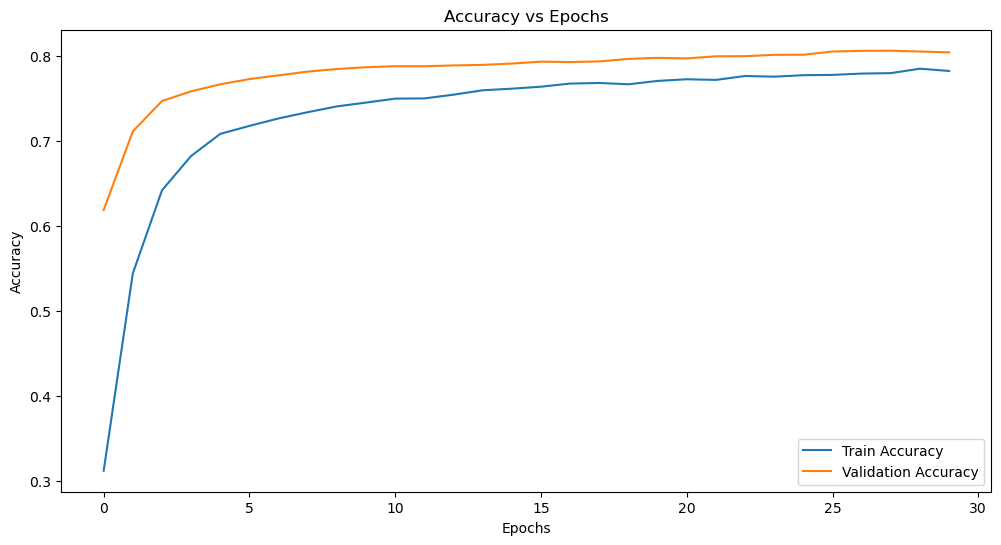

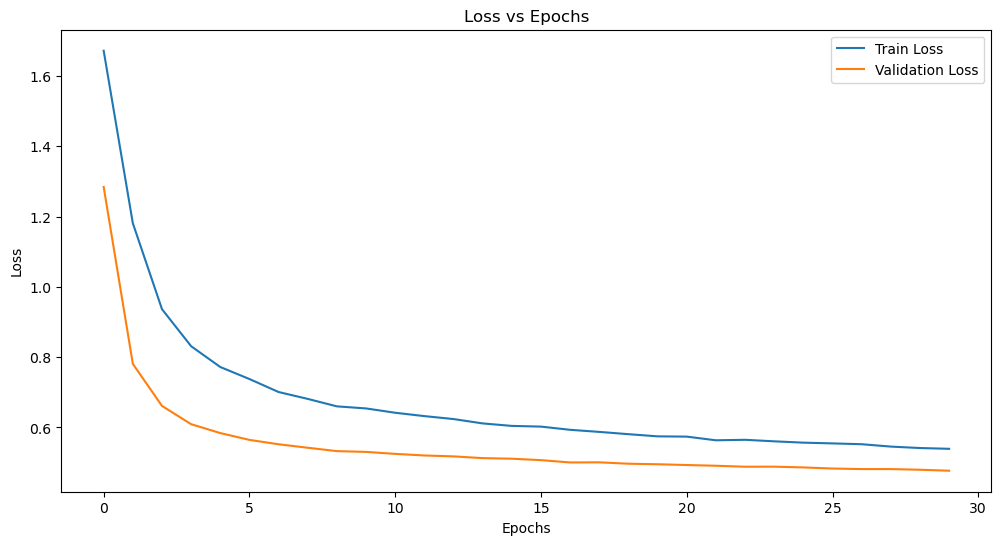

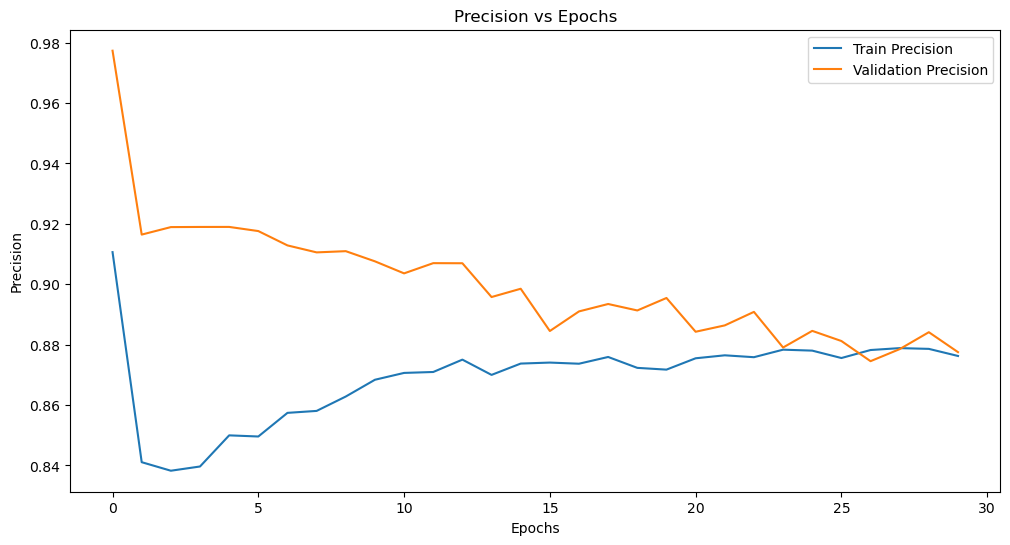

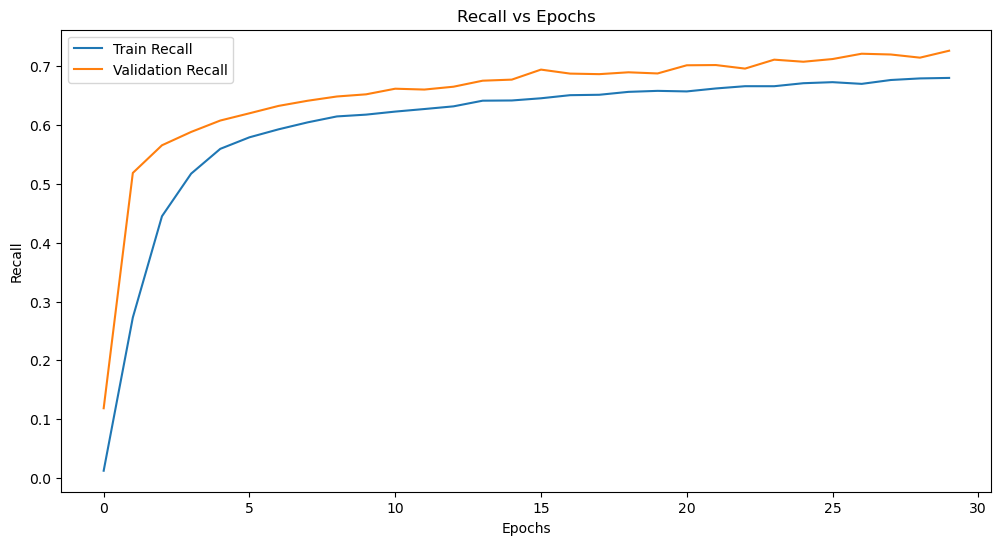

In [11]:
# Plotting Accuracy vs Epochs
plt.figure(figsize=(12, 6))
plt.plot(history_bi_lstm_callbacks.history['accuracy'], label='Train Accuracy')
plt.plot(history_bi_lstm_callbacks.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting Loss vs Epochs
plt.figure(figsize=(12, 6))
plt.plot(history_bi_lstm_callbacks.history['loss'], label='Train Loss')
plt.plot(history_bi_lstm_callbacks.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Precision vs Epochs
plt.figure(figsize=(12, 6))
plt.plot(history_bi_lstm_callbacks.history['precision'], label='Train Precision')
plt.plot(history_bi_lstm_callbacks.history['val_precision'], label='Validation Precision')
plt.title('Precision vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plotting Recall vs Epochs
plt.figure(figsize=(12, 6))
plt.plot(history_bi_lstm_callbacks.history['recall'], label='Train Recall')
plt.plot(history_bi_lstm_callbacks.history['val_recall'], label='Validation Recall')
plt.title('Recall vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()


In [12]:
import pickle
from tensorflow.keras.models import load_model

# Load the saved model
model_bi_lstm_callbacks = load_model('Cyber_Bullying_model_bi_lstm_final.h5')

# Prediction function for new text data
def predict_new_text(new_text):
    # Preprocess the new text
    cleaned_text = clean_and_preprocess_text(new_text)
    
    # Load the saved tokenizer
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    
    # Tokenize and pad the new text
    new_sequence = tokenizer.texts_to_sequences([cleaned_text])
    new_padded = pad_sequences(new_sequence, maxlen=maxlen)
    
    # Load the saved label encoder
    with open('label_encoder.pickle', 'rb') as handle:
        encoder = pickle.load(handle)
    
    # Predict the class
    prediction = model_bi_lstm_callbacks.predict(new_padded)
    predicted_label = encoder.inverse_transform(prediction)
    
    return predicted_label

# Test the prediction function with an example
new_text_example = "U are a fucking idiot school child"
predicted_label = predict_new_text(new_text_example)
print(f"The predicted label for the new text is: {predicted_label[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
The predicted label for the new text is: age


In [21]:
import pickle
from tensorflow.keras.models import load_model

# Load the saved model
model_bi_lstm_callbacks = load_model('Cyber_Bullying_model_bi_lstm_final.h5')
# Plotting Accuracy vs Epochs
plt.figure(figsize=(12, 6))
plt.plot(history_bi_lstm_callbacks.history['accuracy'], label='Train Accuracy')
plt.plot(history_bi_lstm_callbacks.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting Loss vs Epochs
plt.figure(figsize=(12, 6))
plt.plot(history_bi_lstm_callbacks.history['loss'], label='Train Loss')
plt.plot(history_bi_lstm_callbacks.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Precision vs Epochs
plt.figure(figsize=(12, 6))
plt.plot(history_bi_lstm_callbacks.history['precision'], label='Train Precision')
plt.plot(history_bi_lstm_callbacks.history['val_precision'], label='Validation Precision')
plt.title('Precision vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plotting Recall vs Epochs
plt.figure(figsize=(12, 6))
plt.plot(history_bi_lstm_callbacks.history['recall'], label='Train Recall')
plt.plot(history_bi_lstm_callbacks.history['val_recall'], label='Validation Recall')
plt.title('Recall vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()


NameError: name 'history_bi_lstm_callbacks' is not defined

<Figure size 1200x600 with 0 Axes>

In [14]:
# Prediction function for new audio data
def predict_new_audio(audio_file_path):
    # Initialize the recognizer
    recognizer = sr.Recognizer()

    with sr.AudioFile(audio_file_path) as source:
        audio = recognizer.record(source)
        try:
            # Recognize speech using Google Web Speech API
            text = recognizer.recognize_google(audio)
            print(f"Recognized Text: {text}")
            
            # Predict the class for the recognized text
            predicted_label = predict_new_text(text)
            return predicted_label
        except sr.UnknownValueError:
            print("Google Web Speech API could not understand the audio.")
        except sr.RequestError as e:
            print(f"Could not request results from Google Web Speech API; {e}")
    
    return None

# Test the prediction function with an example audio file
audio_file_example = '1.wav'
predicted_label_audio = predict_new_audio(audio_file_example)
if predicted_label_audio:
    print(f"The predicted label for the audio is: {predicted_label_audio[0]}")
else:
    print("Could not predict the label for the audio.")


Recognized Text: you are a Muslim idiot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
The predicted label for the audio is: religion
